<h1><center>«Portfolio-Exam Part II» </center></h1>
<h2><center>MADS-DL </center></h2>
<h3><center>Author: Tom Wüsten </center></h3>

### Introduction
This paper deals with the topic of marketing campaigns in the banking sector. It specifically examines a Portuguese bank whose aim is to sell a product over the phone. This product is a term deposit (deposit in a financial institution with a specific maturity date). The aim of this work is to create a machine learning model that predict the success of a subscriben for a term deposit. The first step in creating a machine learning model is to analyse the data and do a data exploration. The data exploration investigated whether certain age groups, jobs or the number of calls are conspicuously concluding a term deposit. In order to find the best possible machine learning algorithm, different algorithms are compared with each other.



### Dataset Licence
CC BY 4.0 <br>


### Dataset Information:

There are several datasets for this marketing campaign of the bank. I choosed the dataset bank-additional.csv because it has only 10% of the dataset bank-additional-full.csv. The reason is to keep the run time of the notebook low. The reduced dataset contains 4119 instances with 21 attributes, where each instance describes a phone call between a bank employee and a bank customer.
All following information about the attributes are copied from uci machine learning repository. [[1]](#100) <br>
##### bank client data:
1 - age (numeric) <br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') <br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) <br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') <br>
5 - default: has credit in default? (categorical: 'no','yes','unknown') <br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown') <br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown') <br>
#####  related with the last contact of the current campaign: 
8 - contact: contact communication type (categorical: 'cellular','telephone') <br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') <br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri') <br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). <br>
Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. <br>
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#####  other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) <br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) <br>
14 - previous: number of contacts performed before this campaign and for this client (numeric) <br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') <br>
#####  social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) <br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric) <br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) <br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric) <br>
20 - nr.employed: number of employees - quarterly indicator (numeric) <br>

#####  Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no') <br>


### Outline
* [Data Cleansing](#1) <br>
* [Data Exploration](#2) <br>
	* [Relationship between age and subscribing of contracts](#20) <br>
	* [Relationship between job and subscribing of contracts](#21) <br>
	* [Relationship between marketing campaigns and subscribing of contracts](#23) <br>
* [Data Preparation](#3) <br>
* [Classification](#4) <br>
	* [Decision Tree](#5) <br>
		* [balanced Decision Tree](#6) <br>
	* [Random Forest](#7) <br>
		* [balanced Random Forest](#8) <br>
	* [Support Vector Machines](#9) <br>
* [Results](#10) <br>
* [References](#11) <br>

In [75]:
#Load Libaries
import numpy as np
import pandas as pd
import copy
import time
from sklearn.model_selection import train_test_split, GridSearchCV,  RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import  balanced_accuracy_score, confusion_matrix,  f1_score, accuracy_score
import sklearn.metrics as ms
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

### Data Cleansing <a id='1'></a> 
In Data Cleansing the data is checked for duplicates and missing values.

In [3]:
# Load Data
df = pd.read_csv("bank-additional.csv", sep = ";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


The first step in Data Cleaning is checking if the data set contains duplicated rows. No duplicates can be found. We also obtain information about the size of the data. The data represent 4119 rows representing 4119 client records and 21 columns describing the client records.

In [4]:
#Check duplicates
duplicated_rows = df[df.duplicated() == True]
print("The dataset contains "+ str(duplicated_rows.shape[0]) + " fully duplicatated rows.")
df = df.drop_duplicates()
df.shape

The dataset contains 0 fully duplicatated rows.


(4119, 21)

The next step in data cleaning is to analyse whether there is missing data in the columns. The result of the analysis is that the dataset has no missing data.

In [5]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

The data set contains 21 features. The features are numerical (10) and categorical (11). Every row represents a customer which was called by an agent from the bank. 

In [6]:
df.astype('object').describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119,...,4119,4119,4119,4119,4119.0,4119.000,4119.0,4119.000,4119.0,4119
unique,67,12,4,8,3,3,3,2,10,5,...,25,21,7,3,10.0,26.000,26.0,234.000,11.0,2
top,32,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,1.4,93.994,-36.4,4.857,5228.1,no
freq,216,1012,2509,1264,3315,2175,3349,2652,1378,860,...,1764,3959,3523,3523,1626.0,758.000,758.0,274.000,1626.0,3668


### Data Exploration <a id='2'></a> 

The data exploration is intended to gain more domain insight into the available bank data. First, the distribution of the data is investigated, then the numerical features are examined and various plots are created that show insights about the bank's customers. <br>
The feature y shows whether a contract has been concluded after a conversation with the bank employee. A successful contract was concluded for 11.27% and the remaining 88.73% did not conclude a contract. The distribution of the data shows that only a small number of customers concluded the contract. For the later creation of the machine learning model, we must ensure that the same distribution of training examples and test data is maintained. The methods of implementation are shown in the Data Preparation chapter.

In [7]:
distribution = df["y"].value_counts()
print("The dataset contains:"+ str(df.shape[0]) + " samples of phone calls with customers. The subcription of term negative is "+ str(round(distribution[0]/df.shape[0]*100,2)) + "% and the subcription of term positive is "+ str(round(distribution[1]/df.shape[0]*100,2)) + "%.")
print(distribution)

The dataset contains:4119 samples of phone calls with customers. The subcription of term negative is 89.05% and the subcription of term positive is 10.95%.
no     3668
yes     451
Name: y, dtype: int64


The figure 1 shows the distribution of all numerical features. It can be seen that the column age, duration, campaign, pdays and previous got outliers. The feature age will later discussed in the next plot. The feature duration will later be dropped because the influence of this feature is high to the result, also the information about the duration is not known before the call. The feature campaign will be discussed later in the plot Relationship between marketing campaigns and subscribing of contracts. The features shows that the median is around 1000 that means that the most clients has the same value. This feature will further inspected. The last feature with outliers is the feature previous. This feature  previous decribed how many times a client is called before the campaign. This information gains that max nr of 6 is a reasonale numer of previous calls. There is no need to delete outliers.

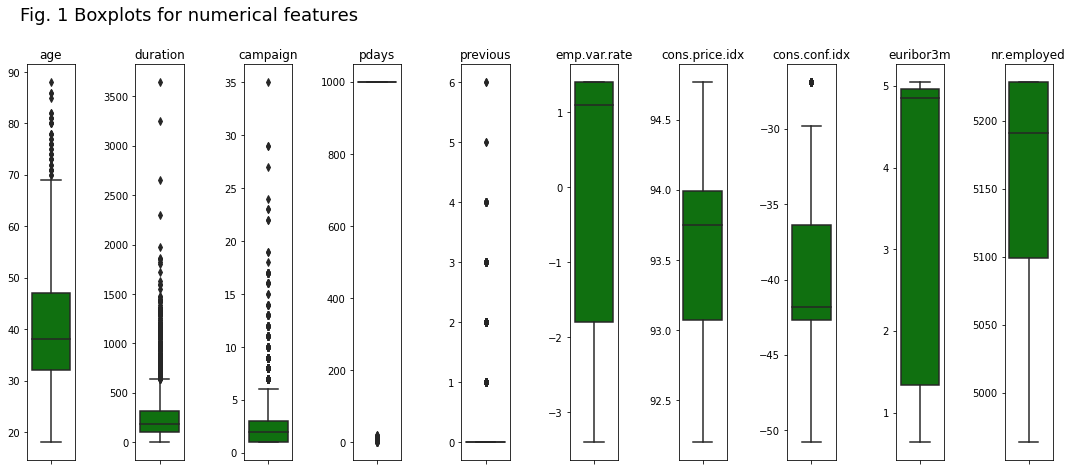

In [8]:
numerical_features =df.select_dtypes(["int64", 'float64'])
numerical_features
inputs = list(numerical_features.columns) #convert the column names to a list
# Determine the number of logging curves
num_inputs = len(inputs)
# Create a figure with 1 row, and num_inputs long
fig, axs = plt.subplots(1,num_inputs)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=1.5, wspace=0.7, hspace=None)
fig.suptitle('Fig. 1 Boxplots for numerical features' , 
             horizontalalignment = 'center', y= fig.subplotpars.right-0.8, fontsize=18)
# Use a for loop to loop over each column in the dataframe and 
# create a separate box plot
for i, (ax, curve) in enumerate(zip(axs.flat, inputs)):
    sns.boxplot(y=numerical_features[curve], ax=ax, color='green', showmeans=False)
    ax.set_title(inputs[i])
    ax.set_ylabel('')
    
plt.subplots_adjust(hspace=0.15, wspace=1.25)
plt.show()

From the information on the dataset, we learned that the feature pdays describes the number of days the customer was contacted after the campaign. The owner of the dataset also mentioned that the value represents 999 customers who were not contacted after the marketing campaign.

In [9]:
df[df["pdays"] == 999].shape[0]
print("After the marketing campaign "+ str(df[df["pdays"] == 999].shape[0]) + " clients were not contacted. That are " + str(round(df[df["pdays"] == 999].shape[0]/df.shape[0]*100,2)) + " % of the clients.")

After the marketing campaign 3959 clients were not contacted. That are 96.12 % of the clients.


#### Relationship between age and subscribing of contracts<a id='20'></a> 
For data analysis, the feature age in relation to contract conclusion is to be examined.  In order to present the data in a more meaningful way, I have sorted the data into age groups. Since there is not as much data for customers over 60 years of age, these customers were sorted into one group. <br>
In Figure 2, the first subplot examines the age structure and the second subplot the age groups with regard to the conclusion of a contract. It can be seen that the majority of customers are in the age group 30-39 , followed by the age group 40-49 and 50-59. The smallest number of customers are in the age group 60+ and 18-19. <br>
The second subplot shows that the rate of contract conclusion is approximately the same for almost all age groups. The exception is the 60+ age group, which clearly stands out with a contract conclusion rate of over 35%. This high rate may also be due to the fact that the number of customers is significantly lower than in the other age groups.

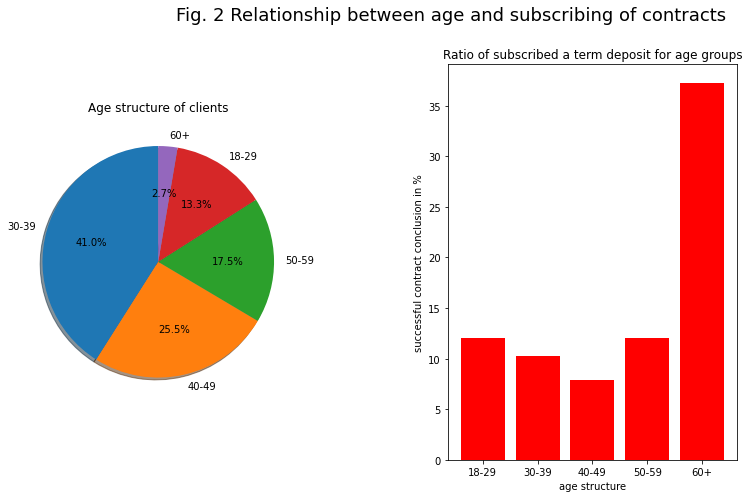

In [10]:
relation_age = pd.DataFrame(df[["age", "y"]])
bins = [18, 29, 39, 49, 59,120]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
relation_age['agerange'] = pd.cut(df.age, bins, labels = labels,include_lowest = False)
relation_age = relation_age.groupby("agerange", as_index=False).agg(Age_percentage = ("agerange", "count")).sort_values(by = "Age_percentage", ascending= False)
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.5, wspace=0.5, hspace=None)
fig.suptitle('Fig. 2 Relationship between age and subscribing of contracts' , 
             horizontalalignment = 'left', y= fig.subplotpars.right-00.1, fontsize=18)
ax[0].pie(relation_age["Age_percentage"], labels= relation_age["agerange"], autopct='%1.1f%%',  pctdistance=0.6,
        shadow=True, startangle=90)
ax[0].set_title('Age structure of clients')
# second
relation_age = pd.DataFrame(df[["age", "y"]])
relation_age['agerange'] = pd.cut(df.age, bins, labels = labels,include_lowest = False)
relation_age = relation_age.groupby(["agerange", "y"], as_index=False).agg(Age_count_y = ("agerange", "count")).sort_values(by = ["agerange","y"], ascending= True)
relation_age = pd.get_dummies(relation_age, columns=["y"])
relation_age["subcribed_counts"] = relation_age["Age_count_y"].shift(-1)
relation_age = relation_age[:-1]
relation_age=relation_age.iloc[::2]
relation_age["subscribe_positive_in_percantage"] = relation_age.apply(lambda x: x["subcribed_counts"]/(x["Age_count_y"]+x["subcribed_counts"])*100, axis=1)
ax[1].bar(relation_age["agerange"], relation_age["subscribe_positive_in_percantage"], color='r')
# Bar Plot
ax[1].set_ylabel('successful contract conclusion in %')
ax[1].set_xlabel('age structure')
ax[1].set_title('Ratio of subscribed a term deposit for age groups')
# Show Plot
plt.show()

#### Relationship between job and subscribing of contracts<a id='21'></a> 
The next analysis will look at the relationship of jobs in relation to contract completions. <br>
Figure 3 shows in the two subplots the different jobs of the customers and the conclusion of contracts in relation to the job. From the first subplot, it can be seen that the bank divides the clients into 12 job categories. The categories do not necessarily have to represent an occupation - see retired, unknown or student. Furthermore, it is clear that the majority of customers are admin, blue-collar or technician. <br>
In the second subplot, it becomes clear that the job categories student and retired stand out in terms of contract conclusions. This may be due to the fact that very little data exists on these types. However, it is also evident that the job types admin and technician also have high completion rates and there is lot of data is available on these job types.

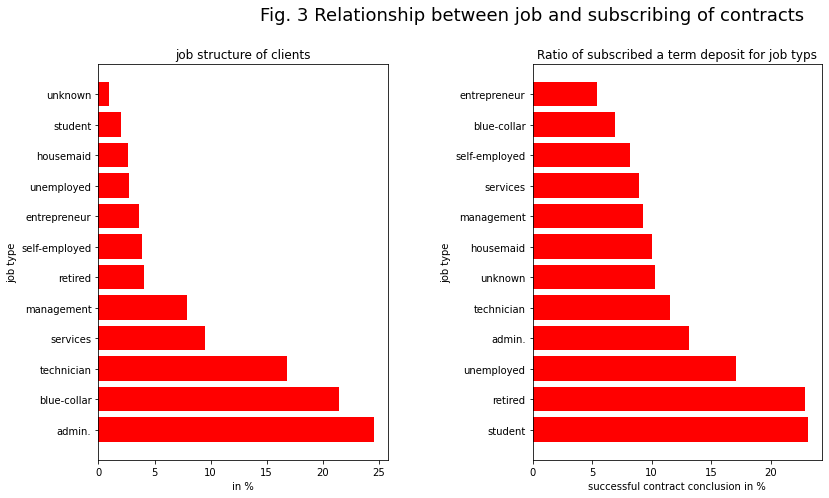

In [11]:
relation_job = pd.DataFrame()
relation_job = df.groupby("job", as_index=False).agg(Job_count = ("default", "count")).sort_values(by = "Job_count", ascending= False)
relation_job["Percentage"] = 100*relation_job["Job_count"]/df.shape[0]
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.5, wspace=0.5, hspace=None)
fig.suptitle('Fig. 3 Relationship between job and subscribing of contracts' , 
             horizontalalignment = 'left', y= fig.subplotpars.right-00.1, fontsize=18)
# Horizontal Bar Plot
ax[0].barh(relation_job["job"], relation_job["Percentage"], color='r')
ax[0].set_ylabel('job type')
ax[0].set_xlabel('in %')
ax[0].set_title('job structure of clients')
# second
relation_job = pd.DataFrame()
relation_job = df.groupby(["job", "y"], as_index=False).agg(job_count_y = ("job", "count")).sort_values(by = ["job","y"], ascending= True)
relation_job = pd.get_dummies(relation_job, columns=["y"])
relation_job["subcribed_counts"] = relation_job["job_count_y"].shift(-1)
relation_job = relation_job[:-1]
relation_job=relation_job.iloc[::2]
relation_job["subscribe_positive_in_percantage"] = relation_job.apply(lambda x: x["subcribed_counts"]/(x["job_count_y"]+x["subcribed_counts"])*100, axis=1)
relation_job = relation_job.sort_values(by= "subscribe_positive_in_percantage", ascending=False)
ax[1].barh(relation_job["job"], relation_job["subscribe_positive_in_percantage"], color='r')
# Horizontal Bar Plot
ax[1].set_ylabel('job type')
ax[1].set_xlabel('successful contract conclusion in %')
ax[1].set_title('Ratio of subscribed a term deposit for job typs')
# Show Plot
plt.show()

#### Relationship between marketing campaigns and subscribing of contracts<a id='22'></a> 
As a final analysis, I would like to look at the number of calls in the marketing campaigns versus the number of contracts signed.  <br>
In Figure 4, the number of calls per marketing campaign is related to the number of contracts signed. In the first subplot, the number of calls in the marketing campaign is examined. This shows that most of the bank's customers are called 1-3 times in a marketing campaign. However, a few customers were also contacted significantly more often. These are summarised under Miscellaneous.  <br>
The second plot contrasts the number of calls with the number of contracts signed. In general, a similar completion rate can be observed for the number of calls 1-4. In addition, a drop in completion rates can then be seen up to call number 11. For higher numbers of calls, a very high success rate of contracts can be seen. These results can be seen as exceptions, as there is very little data for these call numbers. As a conclusion, it can be seen that the success rate of 12% of contract conclusions is applicable for 88% of the customers.

/var/folders/9n/vy16tcl94935dp37ssx_xglw0000gp/T/ipykernel_1473/1227714254.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  relation_campaign = relation_campaign.append(pd.DataFrame({'campaign': ["Miscellaneous"], 'Percentage': [percentage["Percentage"]]}))


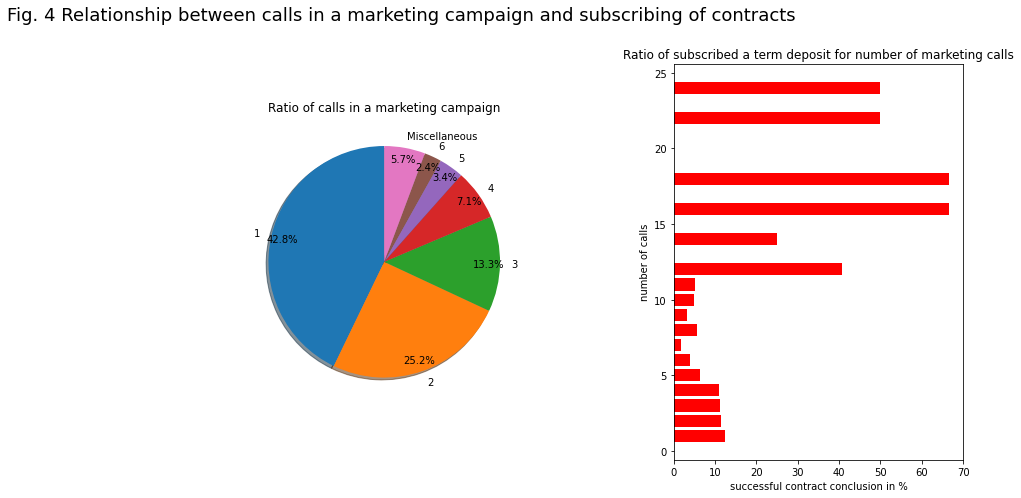

In [12]:
relation_campaign = pd.DataFrame()
relation_campaign = df.groupby("campaign", as_index=False).agg(campaign_count = ("default", "count")).sort_values(by = "campaign_count", ascending= False)
relation_campaign["Percentage"] = 100*relation_campaign["campaign_count"]/df.shape[0]
percentage = relation_campaign[relation_campaign.Percentage < 2].sum()
mask = relation_campaign.Percentage > 2
relation_campaign = relation_campaign[mask]
relation_campaign = relation_campaign.append(pd.DataFrame({'campaign': ["Miscellaneous"], 'Percentage': [percentage["Percentage"]]}))
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.5, wspace=0.5, hspace=None)
fig.suptitle('Fig. 4 Relationship between calls in a marketing campaign and subscribing of contracts' , 
             horizontalalignment = 'center', y= fig.subplotpars.right-00.1, fontsize=18)
# Horizontal Bar Plot
ax[0].pie(relation_campaign["Percentage"],  labels= relation_campaign["campaign"], autopct='%1.1f%%',  pctdistance=0.9,
        shadow=True, startangle=90)
ax[0].set_title('Ratio of calls in a marketing campaign')
# second
relation_campaign = df[df["campaign"] <=30]
relation_campaign = relation_campaign.groupby(["campaign", "y"], as_index=False).agg(campaign_count_y = ("campaign", "count")).sort_values(by = ["campaign","y"], ascending= True)
relation_campaign = pd.get_dummies(relation_campaign, columns=["y"])
relation_campaign["subcribed_counts"] = relation_campaign["campaign_count_y"].shift(-1)
relation_campaign = relation_campaign[:-1]
relation_campaign=relation_campaign.iloc[::2]
relation_campaign["subscribe_positive_in_percantage"] = relation_campaign.apply(lambda x: x["subcribed_counts"]/(x["campaign_count_y"]+x["subcribed_counts"])*100, axis=1)
relation_campaign = relation_campaign.sort_values(by= "subscribe_positive_in_percantage", ascending=False)
ax[1].barh(relation_campaign["campaign"], relation_campaign["subscribe_positive_in_percantage"], color='r')
# Horizontal Bar Plot
ax[1].set_ylabel('number of calls')
ax[1].set_xlabel('successful contract conclusion in %')
ax[1].set_title('Ratio of subscribed a term deposit for number of marketing calls')
# Show Plot
plt.show()

### Data Preparation <a id='3'></a> 

The owner of the dataset provides the information that the feature duration has high impact of the prediction and is not known before the call. Therefore this feature will not be used in ML modells. 

In [13]:
# Drop feature Duration
df = df.drop("duration", 1)

/var/folders/9n/vy16tcl94935dp37ssx_xglw0000gp/T/ipykernel_1473/2800050893.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("duration", 1)


The next step in the Data Preparation is the Machine Learning setup. There I define the target value as y and as X value the rest of data. For the conversion of categorical features into numerical features I use the dummy method. The categorical features are converted into indicator columns (columns of 0s and 1s). This step is necessary because the ML models used to have numerical features. For the conversion of the y feature I used the label encoder, because no new indicator columns are created, but the variable is converted from True to 1 and from False to 0. For the training of the machine learning model, the data is divided into test and training data. I choose 30% of the data set for the test size. Since this is an unbalanced dataset, it is important to specify stratify for y. Stratify ensures that the same ratio of positive and negative contract completions is reflected in the training and test data. I will shuffle the data, as to not preserve any ordering in the data that might be in the data. From the data analysis we learned that the features differ in terms of scale and units. To make the features more comparable, I used the standard scaler.


In [14]:
def ml_setup(df):
    # Encode feature y in numeric feature 
    lb_make = LabelEncoder()
    df['y']= lb_make.fit_transform(df['y'])
    # set traget variable
    y = df["y"]
    # Delete target feature from dataframe
    df1= df.iloc[: , :-1]
    # Encode categorical feature via dummy encoding into numeric feature
    X = pd.get_dummies(df1, columns=['job', 'marital', 'education','default','housing', 'loan','contact','month','day_of_week','poutcome'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify= y, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify= y_train, shuffle=True)
    scaler1 = preprocessing.StandardScaler().fit(X_train)
    X_val_sc = scaler1.transform(X_val)
    X_train_sc = scaler1.transform(X_train)
    X_test_sc = scaler1.transform(X_test)
    return X_train_sc, y_train,X_val_sc,y_val, X_test_sc, y_test

### Classification <a id='4'></a> 
In the chapter Classification, different methods are compared on the basis of metrics. Each experiment follows the same structure. The first step is hyperparameter optimisation using cross validation. The optimal hyperparameters are then used to train the machine learning models. The last step of the experiment is to test the machine learning model using test data. The result obtained is then presented in a confusion matrix, which shows how good the prediction of the model was. In order to compare the different machine learning models, the results are stored in an evaluation dataframe. The evaluation of the models takes place in the chapter Results. <br>
In addition, all the necessary functions for the machine learning models are created in this chapter. This should lead to better clarity in the experiments. <br>
In the following, the machine learning models Decision Tree, Random Forest and Support Vector Machines are used for classification with the aim of predicting whether the customer will conclude a contract with the bank. <br>
In the data analysis, it was found that the data are unbalanced data sets. Therefore, we will briefly define which metrics are useful to make the machine learning models comparable and to be able to assess whether the results are really good or not.

In order to better explain the metrics, individual terms must first be explained. These include the terms Confusion Matrix, True Positive (TP), False Positive (FP), True Negative (TN) and False Negative (FN).  <br>
A confusion matrix is a summary of prediction results on a classification problem. <br>
Using the confusion matrix in figure 5 as an example, I would like to explain the terms TP, FP, TN and FN. <br>
<br>
*   TP: prediction is positive and the result is positiv (in the figure it's 4) <br>
*   FP: prediction is postive and the result is negativ (in the fiugre it's 2) <br>
*   TN: prediction is negtaiv and the result is negativ (in the fiugre it's 1) <br>
*   FN: prediction is negativ and the result is positiv (in the figure it's 3) <br>
<br>
In this dataset the terms would mean:
*   TP: prediction is the subcription of the term deposit and the result is a subcription <br>
*   FP: prediction is the subcription of the term deposit and the result is no subcription <br>
*   TN: prediction is no subcription of the term deposit and the result is a subcription <br>
*   FN: prediction is no subcription of the term deposit and the result is no subcription


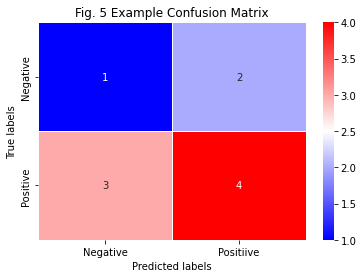

In [15]:
bin_classes=    [0,0,0,1,1,1,1,1,1,1]
bin_predictions=[0,1,1,1,1,1,1,0,0,0]
plot_nr = 5
ms.ConfusionMatrixDisplay.from_predictions(bin_classes, bin_predictions)
ax= plt.subplot()
sns.heatmap(confusion_matrix(bin_classes, bin_predictions), annot=True, fmt='g',cmap = "bwr" ,ax=ax, linewidths=1);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title(f'Fig. {plot_nr} Example Confusion Matrix') 
ax.xaxis.set_ticklabels(['Negative', 'Positiive']);
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

All the formulae shown and discussed here refer only to a binary classifier. <br>
From the data exploration we have learned that it is an inbalanced dataset. Therefore, the accuracy cannot be used because it does not take into account the distribution of the dataset.
The aim of the model is to make the prediction of the subcription of term deposits for a call as accurate as possible. One approach to this is the balanced Accuracy metric, which includes Sensitivity and Specifity. Sensitivity, also called recall, measures the true positive rate. This means how many positive cases were correctly predicted. In contrast, specifity describes the true negative rate. In other words, how many negative cases were correctly predicted. <br>
The second approach the is F1-score, which includes Precision and Recall. Precision defines how good the model predicts the true cases. Our later prediction should have a good precision and a good recall, therefore I used the harmonic mean - F1-score as metric.In my later ml models I want to use both metrics to train and evaluate the models.

\begin{equation*}
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
\end{equation*}
\begin{equation*}
Sensitivty = Recall =  \frac{TP}{TP+FN}
\end{equation*}
\begin{equation*}
Specificity = \frac{TN}{TN+FP}
\end{equation*}
\begin{equation*}
Balanced Accuracy= \frac{Sensitivty+Specificity}{2}
\end{equation*}
\begin{equation*}
Precision = \frac{TP}{TP+FP}
\end{equation*}
\begin{equation*}
F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}
\end{equation*}

The `cross_validate_setting` function finds out the best hyperparameter for the choosen model.

In [16]:
def cross_validate_setting(X,y,model, params):
    """ Form a cross validate setting.
     
    Keywords arguments:
    X       -- input data as dataframe
    y       -- target as dataframe
    model   -- classifier as estimator object
    params  -- hyperparameter as dict
    """    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    clf = GridSearchCV(model, params, scoring='balanced_accuracy', cv=cv, n_jobs = -1)
    search = clf.fit(X,y)
    return search

The `evaluation_df` Dataframe saves all results and is taken for comparison the ML Modells.

In [17]:
evaluation_df = pd.DataFrame({'algorithm':[], 'F1_score':[],'balanced accuracy':[], 'confusion matrix':[],'best hyperparameters':[]})

The function `calc_f1_score` calculates the F1-Score for a given ML modell.

In [18]:
def calc_f1_score(model,x_train,y_train,x_test,y_test):
    """calculate the accuracy of a model
    
    Keywords arguments:
    x_train -- train data as dataframe
    y_train -- train target as dataframe
    x_test  -- test data as dataframe
    y_test  -- test target as dataframe
    model   -- classifier as estimator object
    
    """
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    print(f'The F1-Score for the modell {model} is {round(f1_score(y_test, y_test_pred),2)}.')
    return f1_score(y_test, y_test_pred)

The function `calc_balanced_accuracy_score` calculates the balanced accuracy for a given ML modell.

In [19]:
def calc_balanced_accuracy_score(model,x_train,y_train,x_test,y_test):
    """calculate the balanced accuracy of a model
    
    Keywords arguments:
    x_train -- train data as dataframe
    y_train -- train target as dataframe
    x_test  -- test data as dataframe
    y_test  -- test target as dataframe
    model   -- classifier as estimator object
    
    """
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    print(f'The balanced accuracy score for the modell {model} is {round(balanced_accuracy_score(y_test, y_test_pred),2)}.')
    return balanced_accuracy_score(y_test, y_test_pred)

The function `plot_confusion_matrix` uses the seaborn library to plot a confusion matrix. I used the seaborn libaray to add specific lables and titles.

In [264]:
def plot_cm_matrix(cm,plot_nr, balanced_accuracy_score):
    """create a seaborn heatmap to show the confusion matrix
    
    Keywords arguments:
    cm -- confusion matrix
    plot_nr -- Number of plot
    
    """
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g',cmap = "bwr" ,ax=ax, linewidths=1);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'Fig. {plot_nr} Confusion Matrix with {balanced_accuracy_score:.2f}') 
    ax.xaxis.set_ticklabels(['subscribed no', 'subscribed yes']);
    ax.yaxis.set_ticklabels(['subscribed no', 'subscribed yes']);

The function `plot_all_confusion_matrix` takes the evaluation dataframe and plot from all investigated ML modells the confusion matrix. This should serve for better clarity and comparison when analysing the results.

In [21]:
def plot_all_confusion_matrix(evaluation, plot_nr):
    """create a seaborn heatmap of all models to show the confusion matrix
    
    Keywords arguments:
    evaluation dataframe which has all cofusion matrix of al models included
    """

    fig, ax = plt.subplots(1,5)
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=0.5, wspace=0.5, hspace=None)
    fig.suptitle(f'Fig. {plot_nr} Overview of all Confusion matrix' , 
             horizontalalignment = 'left', y= fig.subplotpars.right-1.8, fontsize=15)
    for i in range(0,evaluation.shape[0]):
        sns.heatmap(evaluation.iloc[i,3].astype('int'), annot=True, fmt='g',cmap = "bwr" ,ax=ax[i], linewidths=1)
        ax[i].set_xlabel('Predicted labels')
        ax[i].set_ylabel('True labels')
        ax[i].set_title(f'CM  {evaluation.iloc[i,0]}')
    plt.show()

    

In [22]:
def compute_accuracy(model, data_loader):
    '''
    compute the overall accuracy 
    of a dataset in a data_loader
    enumerated in batches
    Assumption: model returns a tensor with dimensionality (batch, class probability)
    '''
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader): 
        y_proba = model(features) # predict probabilities for each instance in the current batch
        _, predicted_labels = torch.max(y_proba, dim=1) # reduce dim 1 (columns)

        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [234]:
def get_targets_and_predictions(model, data_loader):
    '''
    create two lists: actual and predicted target 
    of a dataset in a data_loader
    enumerated in batches
    Assumption: model returns a tensor with dimensionality (batch, class probability)
    '''
    all_targets, all_predictions = [], []
    for i, (features, targets) in enumerate(data_loader):
        y_pred = model(features) # predict probabilities for each instance in the current batch
        all_targets.extend(targets)
        all_predictions.extend(np.array(y_pred).round())
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    return all_targets, all_predictions

### MLP

In [259]:
class BinaryClassification(nn.Module):
  def __init__(self,input_shape):
    super(BinaryClassification,self).__init__()
    self.fc1 = nn.Linear(input_shape,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,32)
    self.fc4 = nn.Linear(32,16)
    self.fc5 = nn.Linear(16,8)
    self.fc6 = nn.Linear(8,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    return x

Simple Experiment

In [277]:
X_train_sc, y_train,x_val,y_val, X_test_sc, y_test = ml_setup(df)

In [278]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_train_sc, y_train)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [279]:
#X_train_tensor=torch.from_numpy(X_train_sc).float()
X_train_tensor=torch.from_numpy(X_res).float()
X_val_tensor=torch.from_numpy(x_val).float()
X_test_tensor=torch.from_numpy(X_test_sc).float()
#y_train_tensor=torch.Tensor(y_train.to_numpy()).float()
y_train_tensor=torch.Tensor(y_res).float()
y_val_tensor=torch.Tensor(y_val.to_numpy()).long()
y_test_tensor=torch.Tensor(y_test.to_numpy()).long()

Write Data to Device

In [269]:
X_train_tensor=X_train_tensor.to(device)
X_val_tensor=X_val_tensor.to(device)
X_test_sc=X_test_tensor.to(device)
y_train_tensor=y_train_tensor.to(device)
y_val_tensor=y_val_tensor.to(device)
y_test_tensor=y_test_tensor.to(device)

Create Dataset with TensorDataset

In [280]:
valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Create Dataloaders for Batch processing

In [281]:
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=16,
                          num_workers=4,
                          )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          num_workers=4,
                          drop_last=True,
                          shuffle=True,)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=16,
                         num_workers=4,
                         shuffle=False)

In [282]:
def train_model(model, num_epochs, 
                train_loader, valid_loader,
                optimizer, criterion):

    writer = SummaryWriter()
    best_model_state=copy.deepcopy(model.state_dict())
    best_valid_acc=-float('inf')
    best_epoch=0

    start_time = time.time()
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            y_pred = model(features)
            targets = targets.unsqueeze(-1)
            loss = criterion(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():  
            y, y_pred=get_targets_and_predictions(model=model, data_loader=train_loader)
            train_acc=balanced_accuracy_score(y, y_pred)*100

            y, y_pred=get_targets_and_predictions(model=model, data_loader=valid_loader)
            valid_acc=balanced_accuracy_score(y, y_pred)*100
            
            print(f'Epoch: {epoch} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')

            writer.add_scalars("lenet/acc", {'train': train_acc, 'val': valid_acc}, epoch)
            writer.add_scalar("lenet/loss", loss.item(), epoch)
            writer.flush()
            
            if (valid_acc>best_valid_acc):
                best_valid_acc=valid_acc
                best_epoch=epoch
                best_model_state=copy.deepcopy(model.state_dict())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    writer.close()
    print("Best Validation Epoch: ", best_epoch)
    model.load_state_dict(best_model_state)
    return model

Compability of GPU training for use in Google Colab

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [176]:
import torch.nn.functional as F

In [283]:
torch.manual_seed(1)

model = BinaryClassification(X_res.shape[1])
model.to(device)
criterion=nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = train_model(
    model=model,
    num_epochs=30,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion)

Epoch: 0 | Train: 80.69% | Validation: 67.67%
Time elapsed: 0.05 min
Epoch: 1 | Train: 87.95% | Validation: 67.81%
Time elapsed: 0.10 min
Epoch: 2 | Train: 90.94% | Validation: 67.90%
Time elapsed: 0.15 min
Epoch: 3 | Train: 91.66% | Validation: 68.21%
Time elapsed: 0.20 min
Epoch: 4 | Train: 94.45% | Validation: 67.98%
Time elapsed: 0.24 min
Epoch: 5 | Train: 95.16% | Validation: 65.92%
Time elapsed: 0.29 min
Epoch: 6 | Train: 96.59% | Validation: 66.67%
Time elapsed: 0.34 min
Epoch: 7 | Train: 95.20% | Validation: 61.63%
Time elapsed: 0.39 min
Epoch: 8 | Train: 97.12% | Validation: 63.40%
Time elapsed: 0.43 min
Epoch: 9 | Train: 97.74% | Validation: 66.04%
Time elapsed: 0.48 min
Epoch: 10 | Train: 98.31% | Validation: 64.15%
Time elapsed: 0.53 min
Epoch: 11 | Train: 98.72% | Validation: 62.99%
Time elapsed: 0.58 min
Epoch: 12 | Train: 97.93% | Validation: 62.04%
Time elapsed: 0.63 min
Epoch: 13 | Train: 98.17% | Validation: 63.94%
Time elapsed: 0.68 min
Epoch: 14 | Train: 97.72% | Va

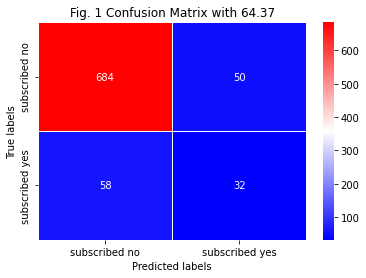

In [284]:
model.eval()
with torch.no_grad(): 
    y, y_pred=get_targets_and_predictions(model=model, data_loader=test_loader)
    train_acc=balanced_accuracy_score(y, y_pred)*100
cm = confusion_matrix(y,y_pred)
plot_cm_matrix(cm, 1, train_acc)

Idea for unbalanced dataset:- add weights to criterion or add SMOTE to the data preprocessing

Pytroch Lighting

In [73]:
import pytorch_lightning as pl

Pytorch Lightning Modell

In [99]:
class BinaryClassificationLightning(pl.LightningModule):
  def __init__(self,input_shape):
    super(BinaryClassificationLightning,self).__init__()
    self.fc1 = nn.Linear(input_shape,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,32)
    self.fc4 = nn.Linear(32,16)
    self.fc6 = nn.Linear(16,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.sigmoid(self.fc4(x))
    return x
  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer
  def training_step(self,batch, batch_nb):
      x, y = batch
      loss = F.cross_entropy(self(x).float(), y.unsqueeze(1).float())
      tensorboard_logs = {'train_loss': loss}
      return {'loss': loss, 'log': tensorboard_logs}
  def validation_step(self, batch, batch_nb):
      x, y = batch
      loss = F.cross_entropy(self(x).float(), y.unsqueeze(1).float())
      tensorboard_logs = {'train_loss': loss}
      return {'loss': loss, 'log': tensorboard_logs}

In [100]:
model = BinaryClassificationLightning(X_res.shape[1])
trainer = pl.Trainer()    
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader) 

/Users/tom.wuesten/privat_code/Deep-Learning-Exam-Part2/.venv/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/tom.wuesten/privat_code/Deep-Learning-Exam-Part2/lightning_logs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 8.1 K 
1 | fc2  | Linear | 8.3 K 
2 | fc3  | Linear | 65    
--------------------------------
16.4 K    Trainable params
0         Non-trainable params
16.4 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]